In [93]:
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec

### Build basis and Hamiltonian

In [118]:
sites=2
###### parameters
L_modes = sites # system size
L_spin = 2
total_boson_number = sites
cutoff = 3 #sites+2
h = 0 # field strength
t = 2
###### create the basis
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson=boson_basis_1d(L=L_modes,sps=cutoff,Nb=total_boson_number)
basis = tensor_basis(basis_spin,basis_boson)
# print(basis)

##### create model
hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
field = [[-h,i] for i in range(L_spin)]
static=[["z|+-",hop],["z|-+",hop],["x|",field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H = hamiltonian(static,[],basis=basis,**no_checks)
# E, _ = H.eigsh(k=2)

### define initial state

In [119]:
##### define initial state #####
#Spin - find index of spin state |01>
ispin = basis_spin.index("01")
#Boson - find index of Fock state |20>
iboson = basis_boson.index("02")
# Ns is the size of the Hilbert space
psispin = np.zeros(basis_spin.Ns,dtype=np.float64) # for 2 bosons in 2 modes Ns=3 ("20","11","02")
psispin[ispin] = 1.0
psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
psiboson[iboson] = 1.0
psi=np.kron(psispin,psiboson)

##### Check state we just made

In [120]:
field = [[1.0,1]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static=[["|n",field]] #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H = hamiltonian(static,[],basis=basis,**no_checks)
print(np.dot(psi.conj().T,H.dot(psi)))

(2+0j)


### Time evolve

In [121]:
t=np.linspace(0,600,100)
print(t)

[  0.           6.06060606  12.12121212  18.18181818  24.24242424
  30.3030303   36.36363636  42.42424242  48.48484848  54.54545455
  60.60606061  66.66666667  72.72727273  78.78787879  84.84848485
  90.90909091  96.96969697 103.03030303 109.09090909 115.15151515
 121.21212121 127.27272727 133.33333333 139.39393939 145.45454545
 151.51515152 157.57575758 163.63636364 169.6969697  175.75757576
 181.81818182 187.87878788 193.93939394 200.         206.06060606
 212.12121212 218.18181818 224.24242424 230.3030303  236.36363636
 242.42424242 248.48484848 254.54545455 260.60606061 266.66666667
 272.72727273 278.78787879 284.84848485 290.90909091 296.96969697
 303.03030303 309.09090909 315.15151515 321.21212121 327.27272727
 333.33333333 339.39393939 345.45454545 351.51515152 357.57575758
 363.63636364 369.6969697  375.75757576 381.81818182 387.87878788
 393.93939394 400.         406.06060606 412.12121212 418.18181818
 424.24242424 430.3030303  436.36363636 442.42424242 448.48484848
 454.54545

In [122]:
psi_t=H.evolve(psi,t[0],t,iterate=True,rtol=1E-9,atol=1E-9)

In [123]:
obs_args={"basis":basis,"check_herm":False,"check_symm":False}
n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)
Obs_t = obs_vs_time(psi_t,t,{"n":n})
O_n = Obs_t["n"]

/tmp/ipykernel_14505/4003040525.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)


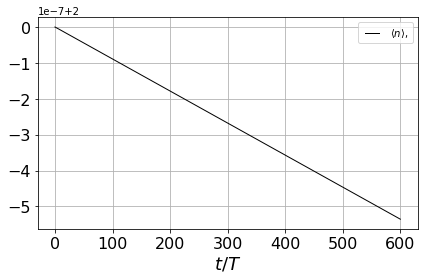

In [125]:
##### plot results #####
import matplotlib.pyplot as plt
import pylab
# define legend labels
str_n = "$\\langle n\\rangle,$"
# plot spin-photon data
fig = plt.figure()
plt.plot(t,np.real(O_n),"k",linewidth=1,label=str_n)
# label axes
plt.xlabel("$t/T$",fontsize=18)
# set y axis limits
# plt.ylim([-1.1,1.4])
# display legend horizontally
plt.legend(loc="upper right",ncol=5,columnspacing=0.6,numpoints=4)
# update axis font size
plt.tick_params(labelsize=16)
# turn on grid
plt.grid(True)
# save figure
plt.tight_layout()
plt.savefig('example3.pdf', bbox_inches='tight')
# show plot
plt.show()
# plt.close()